### Implememting LIME & SHAP

In [30]:
import os
import cv2
import glob
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from skimage.feature import hog, local_binary_pattern
from skimage.segmentation import mark_boundaries
from lime import lime_image
import shap

from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix

In [35]:

models_dir = r'.\trained_models' 
os.makedirs(models_dir, exist_ok=True)

TEST_DIR = r"C:\Users\shera\Desktop\fyp\fyp\dataset\malaria\testing_ds\extracted_by_class"

CLASS_MAP = {
    0: 'difficult', 1: 'gametocyte', 2: 'leukocyte', 3: 'red_blood_cell',
    4: 'ring', 5: 'schizont', 6: 'trophozoite'
}
CLASS_NAMES = [name for idx, name in sorted(CLASS_MAP.items(), key=lambda item: item[1])]


In [ ]:
print(CLASS_NAMES)

In [36]:
def extract_hog_features(image_patch):
    gray_patch = cv2.cvtColor(image_patch, cv2.COLOR_BGR2GRAY)
    return hog(gray_patch, orientations=9, pixels_per_cell=(8, 8),
               cells_per_block=(2, 2), block_norm='L2-Hys', transform_sqrt=True)

def extract_hist_features(image_patch):
    hist = cv2.calcHist([image_patch], [0, 1, 2], None,
                        [8, 8, 8], [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

def extract_lbp_features(image_patch):
    gray_patch = cv2.cvtColor(image_patch, cv2.COLOR_BGR2GRAY)
    radius = 3
    n_points = 8 * radius
    lbp = local_binary_pattern(gray_patch, n_points, radius, 'uniform')
    (hist, _) = np.histogram(lbp.ravel(),
                             bins=np.arange(0, n_points + 3),
                             range=(0, n_points + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    return hist

FEATURE_EXTRACTOR_FNS = {
    'HOG': extract_hog_features,
    'HIST': extract_hist_features,
    'LBP': extract_lbp_features
}


Found 3 Random Forest models to analyze.

ANALYZING RANDOM FOREST MODEL: 128_HIST_rf_model.pkl
Test set built: (7273, 512), labels: 7273


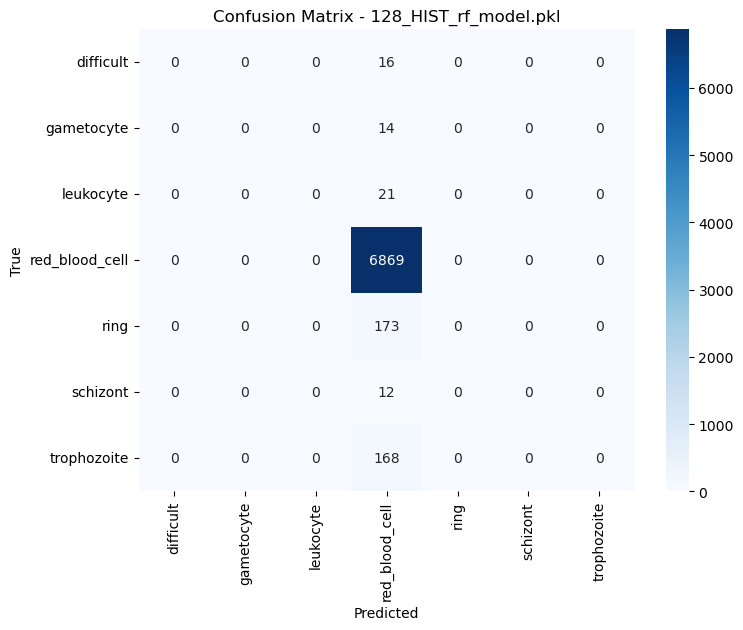

Model classes: [0 1 2 3 4 5 6]


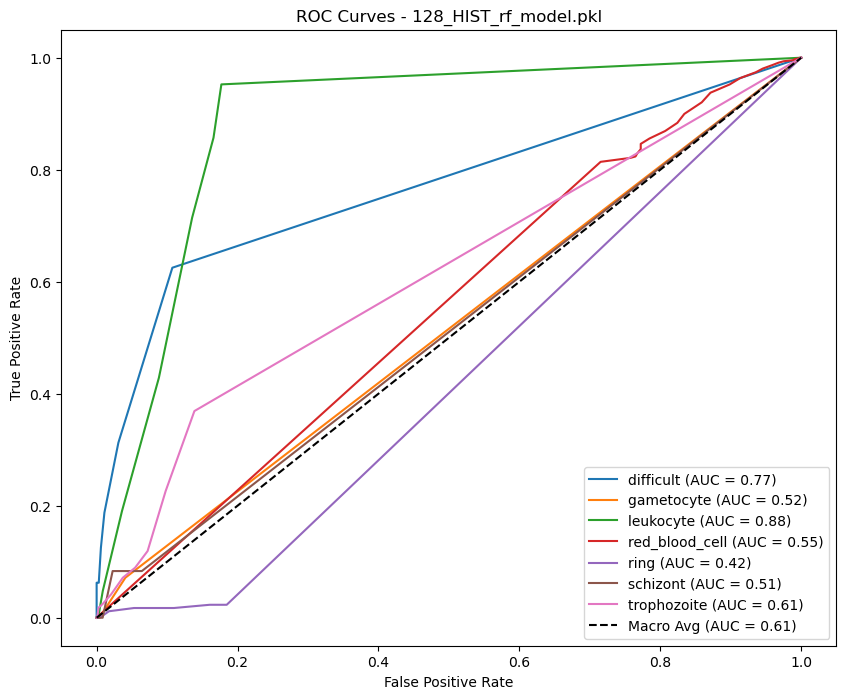

100%|██████████| 1000/1000 [00:04<00:00, 217.29it/s]


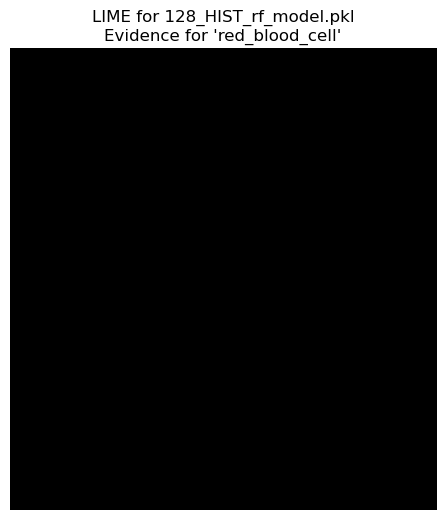


--- FAILED TO ANALYZE MODEL: .\trained_models\128_HIST_rf_model.pkl ---
Error: 'classifier'

ANALYZING RANDOM FOREST MODEL: 128_HOG_rf_model.pkl
Test set built: (7273, 1764), labels: 7273


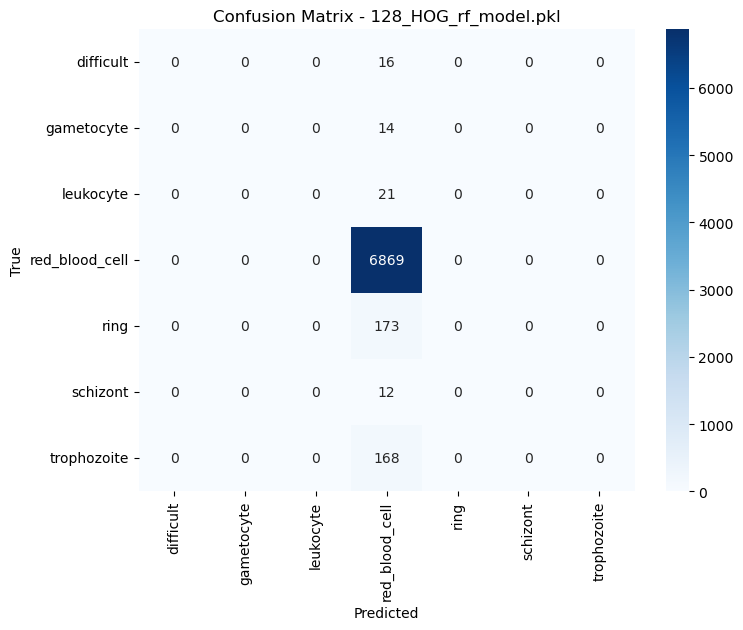

Model classes: [0 1 2 3 4 5 6]


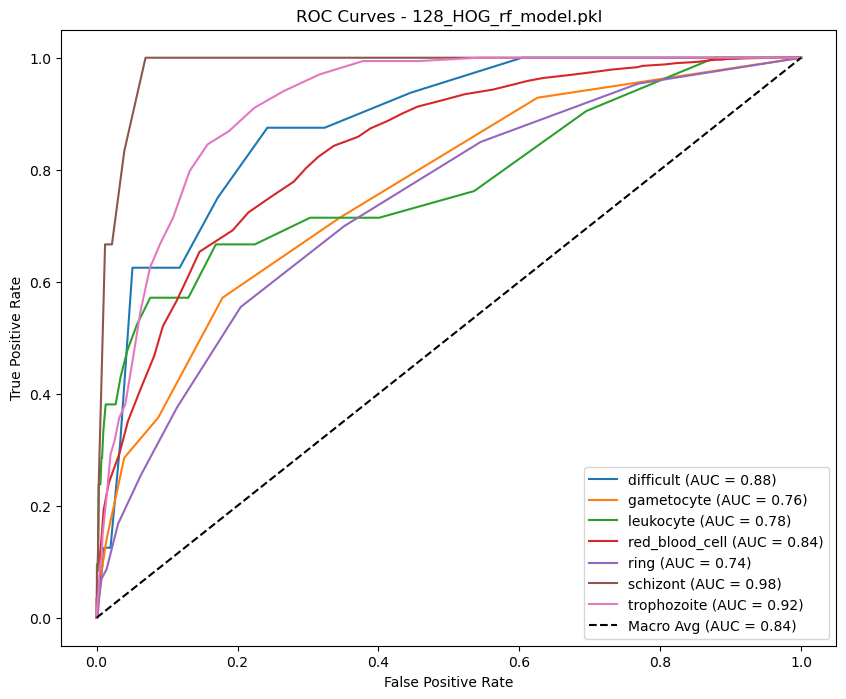

100%|██████████| 1000/1000 [00:06<00:00, 160.31it/s]


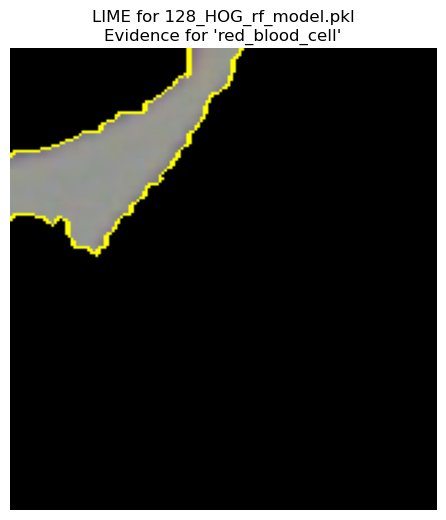


--- FAILED TO ANALYZE MODEL: .\trained_models\128_HOG_rf_model.pkl ---
Error: 'classifier'

ANALYZING RANDOM FOREST MODEL: 128_LBP_rf_model.pkl
Test set built: (7273, 26), labels: 7273


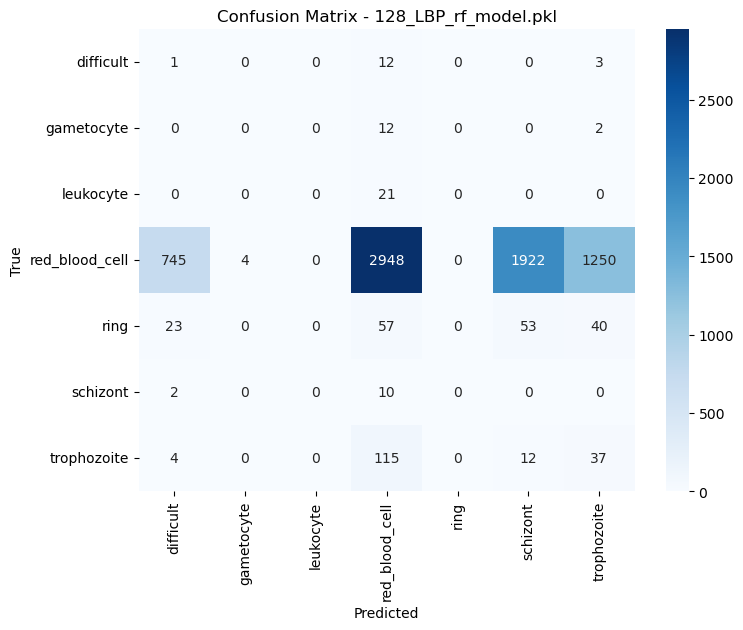

Model classes: [0 1 2 3 4 5 6]


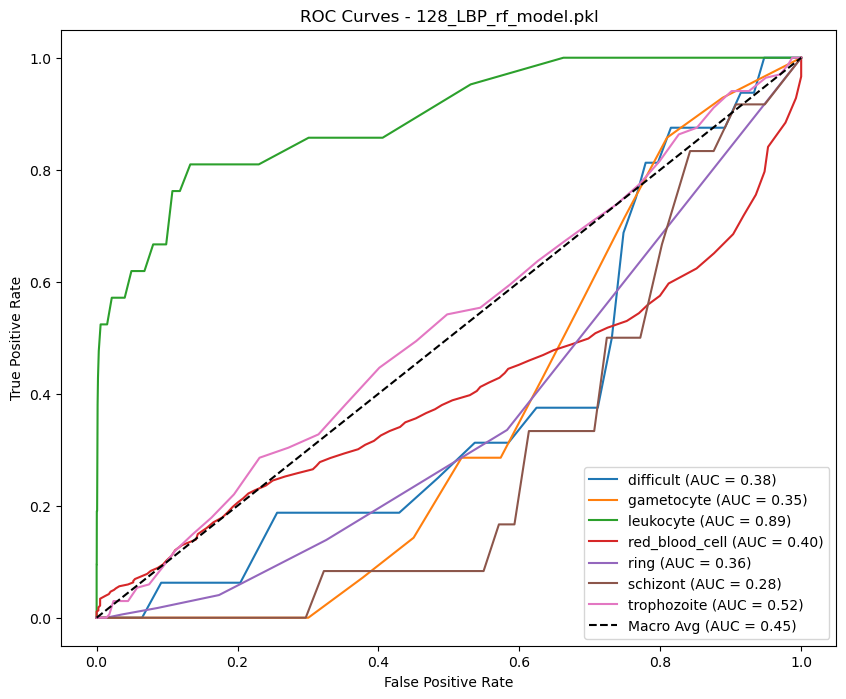

100%|██████████| 1000/1000 [00:13<00:00, 74.88it/s]


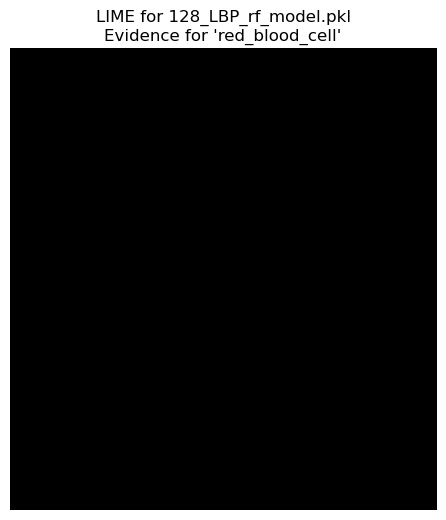


--- FAILED TO ANALYZE MODEL: .\trained_models\128_LBP_rf_model.pkl ---
Error: 'classifier'


In [37]:
model_paths = glob.glob(os.path.join(models_dir, "*.pkl"))

if not model_paths:
    print(f"ERROR: No Random Forest model (.pkl) files found in: {models_dir}")
else:
    print(f"Found {len(model_paths)} Random Forest models to analyze.")

for model_path in model_paths:
    try:
        pipeline = joblib.load(model_path)
        filename = os.path.basename(model_path)
        size_str, feature_type, _ = filename.split('_', 2)

        print(f"\n{'='*60}")
        print(f"ANALYZING RANDOM FOREST MODEL: {filename}")
        print(f"{'='*60}")

        # Override image size for HOG (trained on 64x64)
        image_size = 64 if feature_type == 'HOG' else int(size_str)

        # --- Build Test Set ---
        X_test, y_test = [], []
        for class_idx, class_name in CLASS_MAP.items():
            class_folder = os.path.join(TEST_DIR, class_name)
            if not os.path.isdir(class_folder):
                continue
            for img_file in glob.glob(os.path.join(class_folder, "*.png")):
                img = cv2.imread(img_file)
                if img is None:
                    continue
                resized_img = cv2.resize(img, (image_size, image_size))
                feat = FEATURE_EXTRACTOR_FNS[feature_type](resized_img)
                X_test.append(feat)
                y_test.append(class_idx)

        X_test = np.array(X_test)
        y_test = np.array(y_test)
        print(f"Test set built: {X_test.shape}, labels: {len(y_test)}")

        # --- Predictions ---
        y_score = pipeline.predict_proba(X_test)
        y_pred = np.argmax(y_score, axis=1)

        # --- Confusion Matrix ---
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=CLASS_MAP.values(),
                    yticklabels=CLASS_MAP.values())
        plt.title(f"Confusion Matrix - {filename}")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()

        plt.figure(figsize=(10, 8))

        model_classes = pipeline.classes_
        print("Model classes:", model_classes)

        valid_aucs = []

        for i, cls in enumerate(model_classes):
            y_true_bin = (y_test == cls).astype(int)
            y_score_class = y_score[:, i]

            # Skip if no positives or no negatives
            if len(np.unique(y_true_bin)) < 2:
                print(f"Skipping {CLASS_MAP[cls]} (only one class present in test).")
                continue

            fpr, tpr, _ = roc_curve(y_true_bin, y_score_class)
            roc_auc = auc(fpr, tpr)
            valid_aucs.append(roc_auc)
            plt.plot(fpr, tpr, label=f"{CLASS_MAP[cls]} (AUC = {roc_auc:.2f})")

        # Manual macro average
        if valid_aucs:
            macro_auc = np.mean(valid_aucs)
            plt.plot([0, 1], [0, 1], 'k--',
                    label=f"Macro Avg (AUC = {macro_auc:.2f})")
        else:
            print("No valid classes for macro AUC.")
            macro_auc = np.nan

        plt.title(f"ROC Curves - {filename}")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend(loc="lower right")
        plt.show()


        # --- LIME EXPLANATION (demo on one image) ---
        demo_img_path = glob.glob(os.path.join(TEST_DIR, "ring", "*.png"))[0]
        image_bgr = cv2.imread(demo_img_path)
        img_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

        def predict_proba_for_lime(list_of_rgb_images):
            feats = []
            for arr in list_of_rgb_images:
                bgr_image = cv2.cvtColor(arr.astype(np.uint8), cv2.COLOR_RGB2BGR)
                resized = cv2.resize(bgr_image, (image_size, image_size))
                feats.append(FEATURE_EXTRACTOR_FNS[feature_type](resized))
            return pipeline.predict_proba(np.vstack(feats))

        lime_explainer = lime_image.LimeImageExplainer()
        lime_exp = lime_explainer.explain_instance(
            image=img_rgb, classifier_fn=predict_proba_for_lime,
            top_labels=1, hide_color=0, num_samples=1000
        )
        label = lime_exp.top_labels[0]
        temp, mask = lime_exp.get_image_and_mask(label=label,
                                                 positive_only=True,
                                                 hide_rest=True,
                                                 min_weight=0.01)
        plt.figure(figsize=(6, 6))
        plt.imshow(mark_boundaries(temp / 255.0, mask))
        plt.title(f"LIME for {filename}\nEvidence for '{CLASS_NAMES[label]}'")
        plt.axis("off")
        plt.show()

        # --- SHAP EXPLANATION (TreeExplainer for RF) ---
        resized_for_shap = cv2.resize(image_bgr, (image_size, image_size))
        X_test_single = FEATURE_EXTRACTOR_FNS[feature_type](resized_for_shap).reshape(1, -1)

        # TreeExplainer is optimized for Random Forest
        shap_explainer = shap.TreeExplainer(pipeline.named_steps['classifier'])
        shap_values = shap_explainer.shap_values(X_test_single)

        shap.summary_plot(shap_values, X_test_single,
                          feature_names=[f"feature_{i}" for i in range(X_test_single.shape[1])])

    except Exception as e:
        print(f"\n--- FAILED TO ANALYZE MODEL: {model_path} ---")
        print(f"Error: {e}")
        continue
